In [ ]:
# %%

import sys
sys.path.append('models')

# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/Dissertation/models')
# sys.path.append('/content/drive/MyDrive/Dissertation')

In [ ]:
# %%

# !pip install dask_ml
# !pip install scikeras
# import nltk
# nltk.download('stopwords')
# import nltk
# nltk.download('punkt')

In [ ]:
# %%

# importing libraries
import joblib
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from collections import defaultdict
import matplotlib.pyplot as plt

from logstic_regression import Logistic_Regression
from XGBoost import XGBoost
from naive_bayes import Naive_Bayes
from rnn import RNN
from cnn import CNN
# from models.bert import BERT
from bilstm import BiLSTM

# Load the TextPreprocessor class (assumed to be defined already)
from textpreprocessor import TextPreprocessor
from evaluation_visualization import Evaluation_Visualization

import warnings
warnings.filterwarnings("ignore")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-10-27 20:31:39.809748: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-27 20:31:39.818601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-27 20:31:39.821144: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-27 20:31:39.827608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 20:31:40.244965: W tensorflow/compiler/tf2

Num GPUs Available:  1


I0000 00:00:1730057501.390386 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730057501.394025 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730057501.394059 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
NUM_SAMPLE = 10000
TEST_RATIO=0.2
BATCH_SIZE=512
EPOCHS = 10
MAX_WORD_COUNT = 5000
MAX_LENGTH = 222
OUTPUT_RESULT_DIR = "output/result"
OUTPUT_MODELS_DIR = "output/models"
USE_TEST_DATA = True
INPUT_DIR = f"input/sample_{NUM_SAMPLE}"

os.makedirs(OUTPUT_RESULT_DIR, exist_ok=True)
os.makedirs(OUTPUT_MODELS_DIR, exist_ok=True)

eval_and_visual = Evaluation_Visualization(out_result_dir= OUTPUT_RESULT_DIR, out_models_dir=OUTPUT_MODELS_DIR)

# %% [markdown]

 00. Text Pre-Processing

In [ ]:
# %%

# Initialize the Text Preprocessor
processor = TextPreprocessor(MAX_WORD_COUNT, MAX_LENGTH)

if USE_TEST_DATA:
    # Load data
    df_train = pd.read_csv(os.path.join(INPUT_DIR, 'train_cleaned.csv'))
    df_test = pd.read_csv(os.path.join(INPUT_DIR, 'test_cleaned.csv'))
    # df_test = processor.load_data()
    X_train = df_train['review']
    X_test = df_test['review']
    y_train = df_train['polarity']
    y_test = df_test['polarity']
    # X_train_seq_padded = pickle.load(os.path.join(INPUT_DIR, 'X_train_pad.pkl'))
    # X_test_seq_padded = pickle.load(os.path.join(INPUT_DIR, 'X_test_pad.pkl'))
else:
    # Load data
    df_train, df_test = processor.parallel_load_data()

    df_train_step1 = processor.remove_stopwords(df_train.copy())
    df_test_step1 = processor.remove_stopwords(df_test.copy())

    print('----------TRAIN DATA----------')
    df_train_step2 = processor.filter_by_length_of_sentence(df_train_step1.copy(),50)
    print('----------TEST DATA----------')
    df_test_step2 = processor.filter_by_length_of_sentence(df_test_step1.copy(),50)

    df_train_step3 = processor.sampling_data(df_train_step2, NUM_SAMPLE)
    df_test_step3 = processor.sampling_data(df_test_step2, int(NUM_SAMPLE*TEST_RATIO))

    # Preprocess data
    df_train_step3 = processor.map_polarity(df_train_step3.copy())
    df_test_step3 = processor.map_polarity(df_test_step3.copy())

    # Split data
    X_train, y_train = processor.split_data(df_train_step3)
    X_test, y_test = processor.split_data(df_test_step3)
    
    os.makedirs(INPUT_DIR, exist_ok=True)
    # Save data
    df_train_step3.to_csv(os.path.join(INPUT_DIR, 'train_cleaned.csv'), index=False)
    df_test_step3.to_csv(os.path.join(INPUT_DIR, 'test_cleaned.csv'), index=False)

X_train_tfidf, X_test_tfidf = processor.vectorize_text(X_train, X_test)
X_train_pad, X_test_pad = processor.tokenization_and_padding(X_train, X_test)

MAX_LENGTH = processor.max_length

# %% [markdown]

 04. Recurrent Neural Network

In [ ]:
# %%

# 1. Train Model
rnn = RNN(max_feature=5000, max_length=processor.max_length, epochs=EPOCHS, batch_size=BATCH_SIZE, output_dim=128, optimizer='adam', embedding_dim=32, rnn_unit=64, verbose=1)
rnn.train_model(X_train_pad, y_train, validation_data=(X_test_pad, y_test))

# 2. Random SearchCV
rnn.random_search(X_train_pad, y_train, (X_test_pad, y_test), n_iter=600, cv=3,  random_state=42, n_jobs=1)

_, best_params = eval_and_visual.compare_models_accuracy_and_get_best_params({'Original': rnn.model,
                                                              'RandomizedSearchCV': rnn.random_search_cv}, X_test_pad, y_test)

# 3. Grid SearchCV
rnn.grid_search(X_train_pad, y_train, (X_test_pad, y_test), cv=3, n_jobs=1, best_params=best_params)

_, best_params = eval_and_visual.compare_models_accuracy_and_get_best_params({'RandomizedSearchCV': rnn.random_search_cv,
                                                              'GriddSearchCV': rnn.grid_search_cv}, X_test_pad, y_test)

# 4. Train Best Model
rnn.train_best_model(X_train_pad,y_train, validation_data=(X_test_pad, y_test), best_params= best_params)

# 5. Evaluate and Save Models
eval_and_visual.evaluate_model_class(rnn,X_test_pad, y_test)

rnn.save_model_and_params(
    os.path.join(OUTPUT_MODELS_DIR, 'rnn_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'rnn_best_model.pkl'),
    os.path.join(OUTPUT_MODELS_DIR, 'rnn_best_params.pkl')
    )

I0000 00:00:1730057501.737014 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730057501.737088 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730057501.737108 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730057501.895487 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730057501.895533 1540197 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-27

Epoch 1/10


I0000 00:00:1730057502.900523 1540851 service.cc:146] XLA service 0x99e36e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730057502.900550 1540851 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-27 20:31:42.919250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-27 20:31:43.069109: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


 1/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.4727 - loss: 0.6990

I0000 00:00:1730057503.480790 1540851 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - accuracy: 0.5209 - loss: 0.6927 - val_accuracy: 0.5535 - val_loss: 0.6847
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6002 - loss: 0.6668 - val_accuracy: 0.6140 - val_loss: 0.6688
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.7895 - loss: 0.6005 - val_accuracy: 0.5765 - val_loss: 0.6697
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.7399 - loss: 0.5512 - val_accuracy: 0.5765 - val_loss: 0.6721
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.8795 - loss: 0.4576 - val_accuracy: 0.5875 - val_loss: 0.6789
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 244ms/step - accuracy: 0.5175 - loss: 0.6913 - val_accuracy: 0.5140 - val_loss: 0.6929
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.6565 - loss: 0.6566 - val_accuracy: 0.5555 - val_loss: 0.6949
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 205ms/step - a

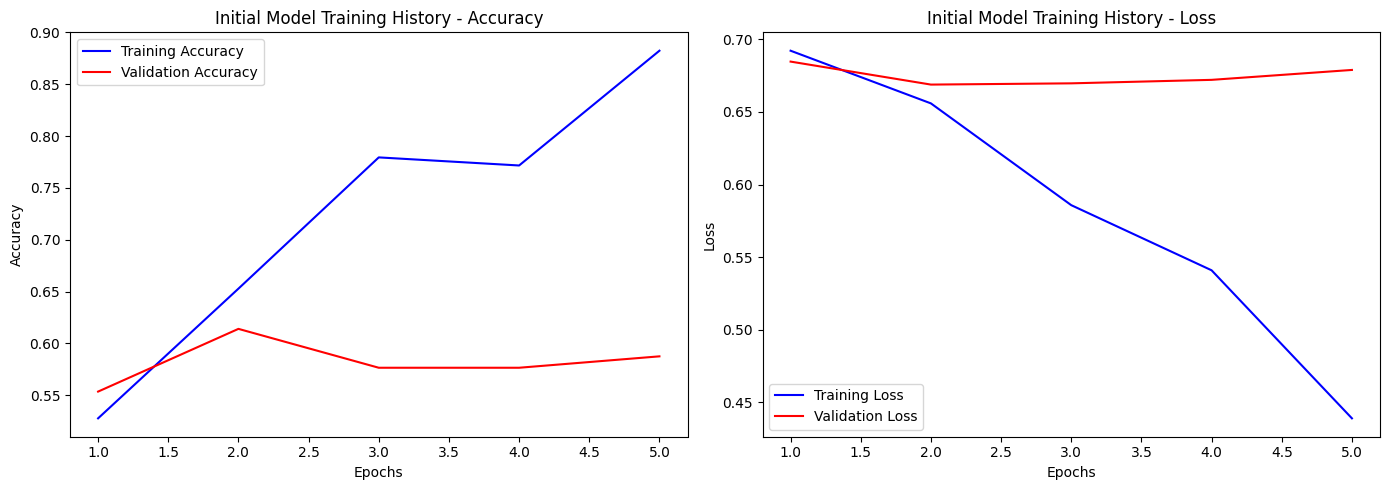

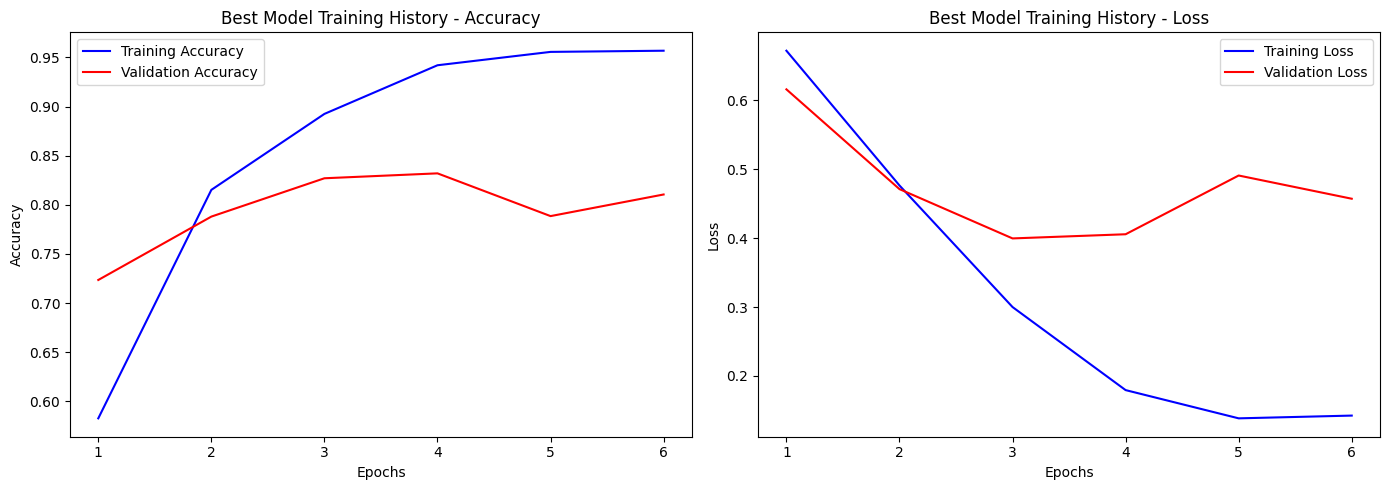

In [ ]:
# %%

# Plot for hist
eval_and_visual.plot_training_history_from_dict(rnn.model.history_, title="Initial Model Training History")

# Plot the training history from defaultdict data
eval_and_visual.plot_training_history_from_dict(rnn.best_model.history_, title="Best Model Training History")

Best Parameters: {'batch_size': 512, 'embedding_dim': 128, 'epochs': 15, 'optimizer': 'rmsprop'}
